In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [8]:
train = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_after_gen.csv')
test = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/test_after_gen.csv')

## EDA

Для начала, разметим данные по категориям.

In [9]:
def type_optimization(df):
    for feature in df.columns:
        if df[feature].dtype == 'str': 
            df[feature] = df[feature].astype('category')
        elif df[feature].nunique() == 2:
            df[feature] = train[feature].astype('category')
        elif df[feature].dtype == 'int64':
            df[feature] = df[feature].astype('int')
        elif df[feature].dtype == 'float64':
            df[feature] = df[feature].astype('float')  
            
type_optimization(train)
type_optimization(test)

continitous_features = [feature for feature, dtype in train.dtypes.items() if dtype == "int" or dtype == "float"]
categorical_features = [feature for feature, dtype in train.dtypes.items() if dtype == "category"]


Рассмотрим распределение признаков 'source_system_tab', 'source_screen_name' и 'source_type'

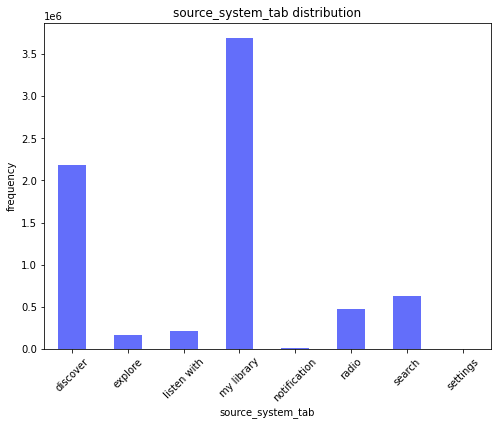

In [10]:
plt.figure(figsize=(8, 6))
train['source_system_tab'].value_counts().sort_index().plot(kind='bar', color='#636EFA')
plt.title('source_system_tab distribution')
plt.xlabel('source_system_tab')
plt.ylabel('frequency')
plt.xticks(rotation=45)
plt.show()

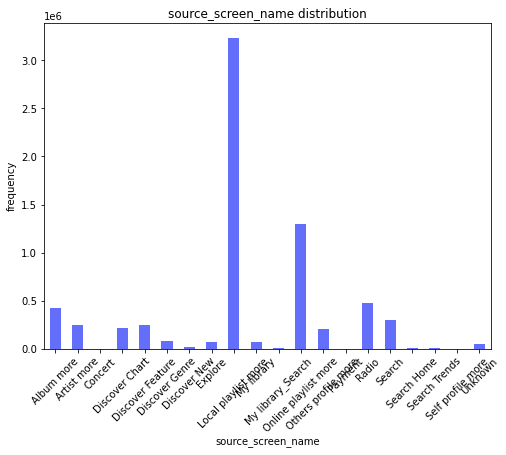

In [11]:
plt.figure(figsize=(8, 6))
train['source_screen_name'].value_counts().sort_index().plot(kind='bar', color='#636EFA')
plt.title('source_screen_name distribution')
plt.xlabel('source_screen_name')
plt.ylabel('frequency')
plt.xticks(rotation=45)
plt.show()

Видно, что основная часть пользователей начинает прослушивание трека с собственной медиатеки - доверие собственным вкусам и радость при прослушивании знакомых и полюбившихся треков вытесняет желание пробовать что-то новое.

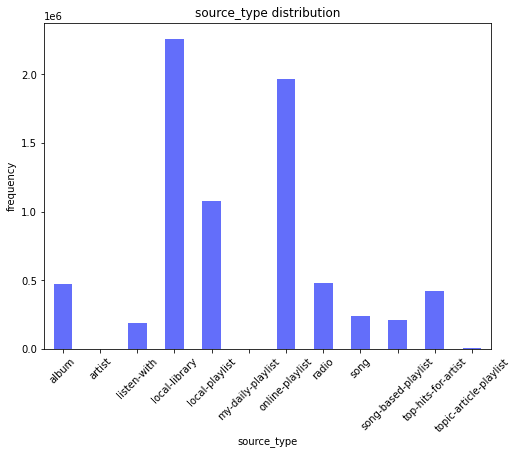

In [12]:
plt.figure(figsize=(8, 6))
train['source_type'].value_counts().sort_index().plot(kind='bar', color='#636EFA')
plt.title('source_type distribution')
plt.xlabel('source_type')
plt.ylabel('frequency')
plt.xticks(rotation=45)
plt.show()

Однако на этом графике заметно и то, что пользователи пользуются my-daily-playlist (что, я полагаю, есть сгенерированные стримингом плейлисты на основе изучения вкусов юзера) почти так же часто, как собственной библиотекой. Этот график отвечает на вопрос о важности рекоммендаций в современных стриминговых платформах.

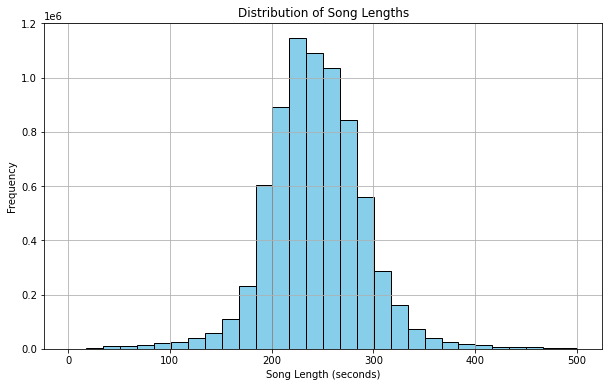

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(train[train['song_length'] < 500]['song_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Song Lengths')
plt.xlabel('Song Length (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Распределение длины песен в выборки отвечает нормальному с выборочным средним около 240 секунд (~4 минут). Интересный результат, поскольку в эпоху фастфудного потребления контента люди стаи более склонны слушать более короткие треки (нередко не достигающие и 3 минут).

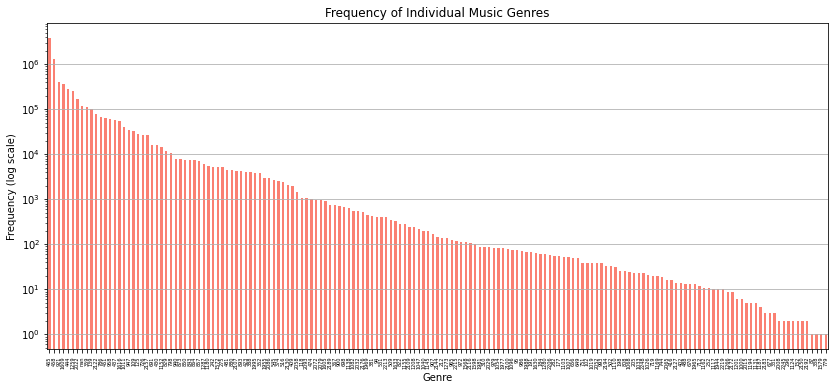

In [14]:
genre_lists = train['genre_ids'].astype(str).str.split('|')
all_genres = [genre for sublist in genre_lists for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()
genre_counts_sorted = genre_counts.sort_values(ascending=False)
filtered_genre_counts = genre_counts_sorted[genre_counts_sorted > 0.001]
plt.figure(figsize=(14, 6))
filtered_genre_counts.plot(kind='bar', color='salmon')
plt.yscale('log')
plt.title('Frequency of Individual Music Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency (log scale)')
plt.xticks(rotation=90, fontsize=5)
plt.grid(axis='y')
plt.show()

Жанры - ещё одна большая тема для исследования. Так как одна песня может относиться к нескольким жанрам, то значение genre_ids у песни может выглядеть как 4313/43/1 ведь, к сожалению, предоставленные стримингом жанры были закодированы в числовые данные. При наличии строковых их названий можно было бы провести генерацию признаков на основе существующих в открытом доступе эмбеддингов для кластеризации жанров по музыкальной схожести. 

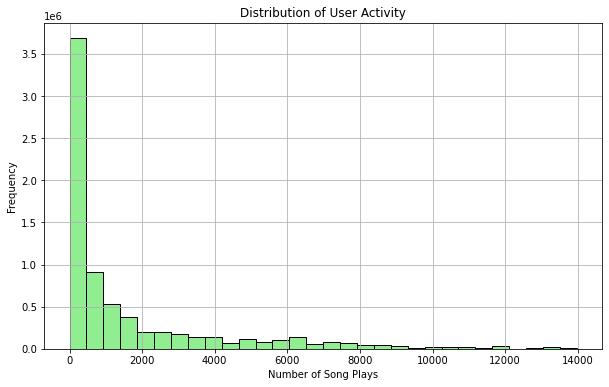

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(train['num_played'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of User Activity')
plt.xlabel('Number of Song Plays')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Здесь можно заметить убывающий характер зависимости количества прослушиваний у каждой отдельной песни от количества различных юзеров, что её прослушивали в выборке. 

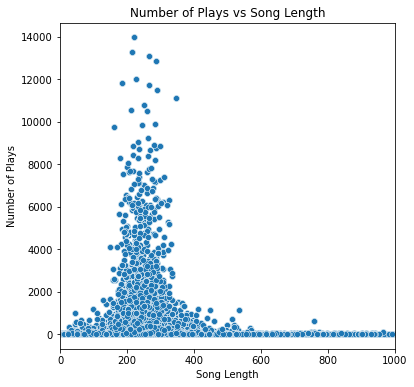

In [16]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='song_length', y='num_played', data=train)
plt.title('Number of Plays vs Song Length')
plt.xlabel('Song Length')
plt.ylabel('Number of Plays')
plt.xlim(0, 1000)
plt.show()

На диаграмме рассеяния можно заметить зависимости между количеством прослушивания трека и его длиной - более всего переслушивать предпочитают треки около матожидания распределения song_length, то есть 240.

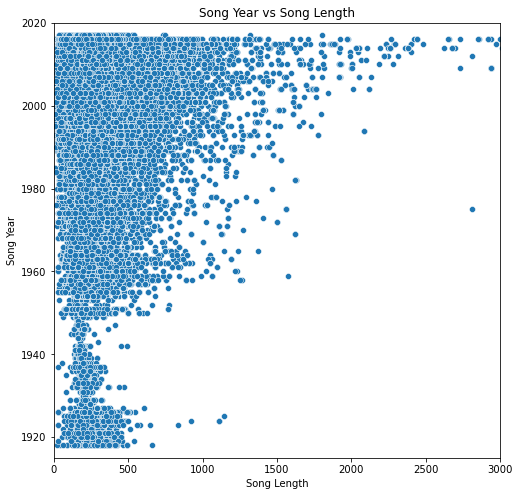

In [17]:
train_copy = train.copy()
train_copy = train_copy[train_copy['song_year'] != 'Unknown']

plt.figure(figsize=(8, 8))
sns.scatterplot(x='song_length', y='song_year', data=train_copy)
plt.title('Song Year vs Song Length')
plt.xlabel('Song Length')
plt.xlim(0, 3000)
plt.ylim(1915, 2020)
plt.ylabel('Song Year')
plt.show()

Эти данные интересны с точки зрения исторической справки для аналитики - заметим, что в наши дни стало больше треков аномальной длины - так как это стриминг, можно предположить, что это подкасты. Однако это можно связать и с большим разнообразием ранородных музыкальных произведений в наши дни и простоту загрузки их на стриминги. 
Интересно и просмотреть на тенденцию того, как в тяжелые для мира времена в 1930-1950 года длительность песен сконцентрировалось около 250 секунд - эжто может быть связано как с тем, что произведения того периода выгружали на стриминги очень выборочно, так и с тем, что в период войны была наибольшая концентрация песен, акцентирующих внимание на патриотизме, национальной идентичности, подбодрении духа (которые в виду формата могли бы требовать не очень большой продолжительности).

А здесь представлены данные по пользовательской активности в зависимости от города - к сожалению, данные о геолокации пользователя так же представлены в закодированном формате, но это не помешает нам посмотреть на ящик с усами, медианы по разным городам, на города-музыкальные лидеры и на выбросы.

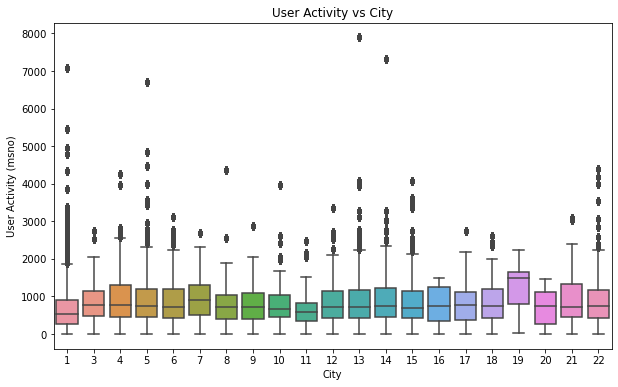

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='user_activity_msno', data=train)
plt.title('User Activity vs City')
plt.xlabel('City')
plt.ylabel('User Activity (msno)')
plt.show()

И последний график относится к зависимости пользовательской активности от года регистрации. Так, гипотеза заключается в том, что недавно зарегестрироавшиеся пользователи более активны на сервисе. Так, она косвенно подтверждается данными.

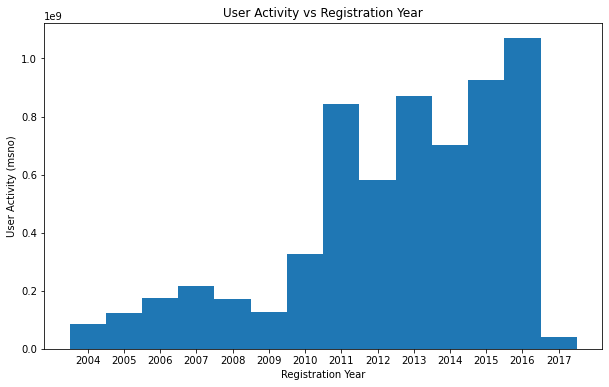

In [19]:
train_numeric = train[['registration_year', 'user_activity_msno']].copy()
train_numeric = train_numeric.dropna(subset=['registration_year'])
train_numeric['user_activity_msno'] = pd.to_numeric(train_numeric['user_activity_msno'], errors='coerce')
train_numeric = train_numeric.dropna(subset=['user_activity_msno'])
unique_years = train_numeric['registration_year'].unique()
unique_years.sort()

bins = [year - 0.5 for year in unique_years]
bins.append(unique_years[-1] + 0.5)

plt.figure(figsize=(10, 6))
plt.hist(x='registration_year', bins=bins, weights='user_activity_msno', data=train_numeric)
plt.title('User Activity vs Registration Year')
plt.xlabel('Registration Year')
plt.ylabel('User Activity (msno)')
plt.xticks(unique_years)
plt.show()